# Style transfer using GANs

* dataset: 17flowers 
* Image A: Pansy flower (image_1281 to image_1360)
* Image B: Tigerlily flower (image_0481 to image_0560)


In [1]:
import itertools
from pathlib import Path
import random

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms
import torchvision.utils as vutils


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
dataroot = Path("data/17flowers")
workers = 2

image_size = 64
image_channels = 3
batch_size = 8


In [4]:
class ImageDataset(Dataset):
    def __init__(self, root, transform=None, unaligned=False, mode='train'):
        self.transform = transform
        self.unaligned = unaligned

        self.files_A = sorted(Path(root, 'A').glob('*.*'))
        self.files_B = sorted(Path(root, 'B').glob('*.*'))

    def __getitem__(self, index):
        item_A = Image.open(self.files_A[index % len(self.files_A)])
        item_B = Image.open(self.files_B[index % len(self.files_B)])

        if self.unaligned:
            item_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])

        if self.transform:
            item_A = self.transform(item_A)
            item_B = self.transform(item_B)

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

dataset = ImageDataset(
    root=dataroot, 
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
)

train_dataset, valid_dataset = train_test_split(dataset, test_size=0.1)


In [5]:
# ? dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)


Text(0.5, 1.0, 'Training Images (Type B)')

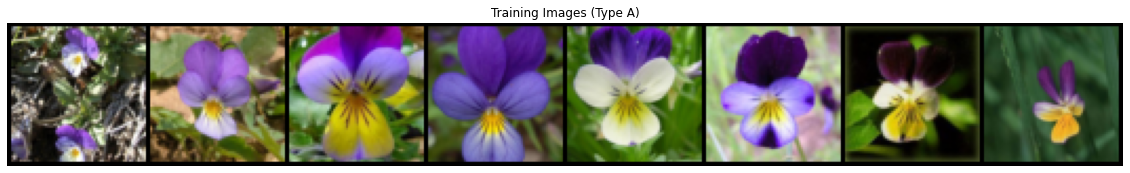

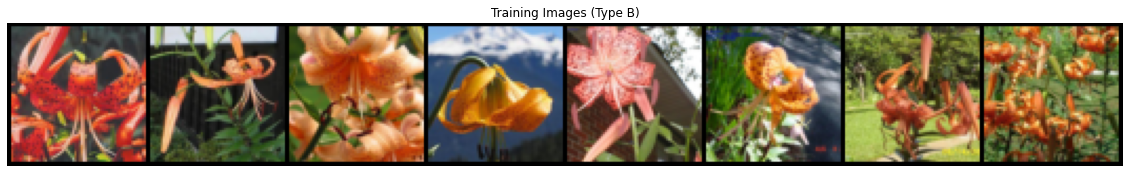

In [6]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(20, 20))
plt.imshow(np.transpose(vutils.make_grid(real_batch['A'], padding=2, normalize=True), (1, 2, 0)))
plt.axis("off")
plt.title("Training Images (Type A)")

plt.figure(figsize=(20, 20))
plt.imshow(np.transpose(vutils.make_grid(real_batch['B'], padding=2, normalize=True), (1, 2, 0)))
plt.axis("off")
plt.title("Training Images (Type B)")


In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)


In [8]:
class PrintLayer(nn.Module):
    def __init__(self, title=None):
        super().__init__()
        self.title = title

    def forward(self, x):
        print(self.title, x.shape)

        return x


In [33]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # ? size of feature maps
        self.num_features = 64

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, self.num_features, 7, padding=3),
            nn.InstanceNorm2d(self.num_features),
            nn.ReLU(inplace=True),

            nn.Conv2d(self.num_features, self.num_features * 2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(self.num_features * 2),
            nn.ReLU(inplace=True),

            nn.Conv2d(self.num_features * 2, self.num_features * 4, 3, stride=2, padding=1),
            nn.InstanceNorm2d(self.num_features * 4),
            nn.ReLU(inplace=True),

            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),
            ResidualBlock(self.num_features * 4),

            nn.ConvTranspose2d(self.num_features * 4, self.num_features * 2, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(self.num_features * 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.num_features * 2, self.num_features, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(self.num_features),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, out_channels, 7, padding=3),

            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)

# ? RGB images
netG_A2B = Generator(in_channels=image_channels, out_channels=image_channels).to(device)
netG_B2A = Generator(in_channels=image_channels, out_channels=image_channels).to(device)

print(netG_A2B)


Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceN

In [34]:
# ? neural network for discriminative model
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        # ? size of feature maps
        self.num_features = 64
        
        self.model = nn.Sequential(
            # ? shape => [3, 64, 64]
            nn.Conv2d(in_channels, self.num_features, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # ? shape => [64, 32, 32]

            nn.Conv2d(self.num_features, self.num_features * 2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(self.num_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # ? shape => [128, 16, 16]

            nn.Conv2d(self.num_features * 2, self.num_features * 4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(self.num_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # ? shape => [256, 8, 8]

            nn.Conv2d(self.num_features * 4, self.num_features * 8, 4, padding=1),
            nn.InstanceNorm2d(self.num_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # ? shape => [512, 7, 7]

            nn.Conv2d(self.num_features * 8, 1, 4, padding=1),
            # ? shape => [1, 6, 6]
        )

    def forward(self, x):
        # ? x: in_shape => [batch_size, 3, 64, 64], out_shape => [batch_size, 1, 6, 6]
        x = self.model(x)

        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

netD_A = Discriminator(in_channels=image_channels).to(device)
netD_B = Discriminator(in_channels=image_channels).to(device)
print(netD_A)


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)


In [35]:
# ? losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# ? optimizers (for both G and D)
lr = 0.0002

optimizerG = optim.Adam(
    itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
    lr=lr,
    betas=(0.5, 0.999)
)

optimizerD_A = optim.Adam(netD_A.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerD_B = optim.Adam(netD_B.parameters(), lr=lr, betas=(0.5, 0.999))


In [36]:
target_real = torch.ones(batch_size, device=device)
target_fake = torch.zeros(batch_size, device=device)

# ? batch of latent vectors to visualize the progression of the generator
input_A = torch.randn(batch_size, image_channels, image_size, image_size, device=device)
input_B = torch.randn(batch_size, image_channels, image_size, image_size, device=device)

print(input_A.shape)


torch.Size([8, 3, 64, 64])


## Training loop

In [38]:
img_list_A = []
img_list_B = []

epoch_losses_G = []
epoch_losses_D_A = []
epoch_losses_D_B = []

num_epochs = 101

print("Starting training loop...")

for epoch in range(num_epochs):
    losses_G = []
    losses_D_A = []
    losses_D_B = []
    

    for i, batch in enumerate(train_dataloader, 0):
        real_A, real_B = batch['A'].to(device), batch['B'].to(device)

        #**** Generator A2B & B2A ****#
        optimizerG.zero_grad()

        # ? Identity loss
        # ? G_B2A(A) should equal A if real A is fed
        # ? G_A2B(B) should equal B if real B is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0
        
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B) * 5.0

        # ? GAN loss
        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)
        
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        # ? Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * 10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * 10.0

        loss_G = (
            loss_identity_A + loss_identity_B + 
            loss_GAN_A2B + loss_GAN_B2A + 
            loss_cycle_ABA + loss_cycle_BAB
        )

        # ? calculate gradients & update G
        loss_G.backward()

        optimizerG.step()
        #*****************************#

        #****** Discriminator A ******#
        optimizerD_A.zero_grad()

        # ? Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # ? Fake loss
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # ? Total loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        losses_D_A.append(loss_D_A.item())

        loss_D_A.backward()

        optimizerD_A.step()
        #*****************************#

        #****** Discriminator B ******#
        optimizerD_B.zero_grad()

        # ? Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        losses_D_B.append(loss_D_B.item())

        loss_D_B.backward()

        optimizerD_B.step()
        optimizerD_B.step()
        #*****************************#

    epoch_losses_G.append(sum(losses_G) / batch_size)
    epoch_losses_D_A.append(sum(losses_D_A) / batch_size)
    epoch_losses_D_B.append(sum(losses_D_B) / batch_size)

    # ? Output training stats
    print(
        f"[{epoch}/{num_epochs}]\t"
        f"Loss_D_A: {loss_D_A:.4f}\t"
        f"Loss_D_B: {loss_D_B:.4f}\t"
        f"Loss_G: {loss_G:.4f}\t"
    )

    if (epoch % 10 == 0):
        with torch.no_grad():
            fake_A = netG_B2A(input_B).detach().cpu()
            fake_B = netG_A2B(input_A).detach().cpu()

        img_list_A.append(vutils.make_grid(fake_A, padding=2, normalize=True))
        img_list_B.append(vutils.make_grid(fake_B, padding=2, normalize=True))

        vutils.save_image(img_list_A[-1], f"results/B2A_{epoch}.png")
        vutils.save_image(img_list_B[-1], f"results/A2B_{epoch}.png")


Starting training loop...
[0/100]	Loss_D_A: 0.3224	Loss_D_B: 0.4209	Loss_G: 9.7297	
[1/100]	Loss_D_A: 0.2027	Loss_D_B: 0.1551	Loss_G: 9.8727	
[2/100]	Loss_D_A: 0.2042	Loss_D_B: 0.2261	Loss_G: 9.9885	
[3/100]	Loss_D_A: 0.1879	Loss_D_B: 0.2550	Loss_G: 9.7105	
[4/100]	Loss_D_A: 0.2836	Loss_D_B: 0.2184	Loss_G: 10.7218	
[5/100]	Loss_D_A: 0.1790	Loss_D_B: 0.1713	Loss_G: 7.5613	
[6/100]	Loss_D_A: 0.1972	Loss_D_B: 0.2929	Loss_G: 9.1506	
[7/100]	Loss_D_A: 0.1585	Loss_D_B: 0.0685	Loss_G: 8.3769	
[8/100]	Loss_D_A: 0.0755	Loss_D_B: 0.0526	Loss_G: 8.8591	
[9/100]	Loss_D_A: 0.2249	Loss_D_B: 0.2476	Loss_G: 8.5673	
[10/100]	Loss_D_A: 0.1294	Loss_D_B: 0.1225	Loss_G: 8.6782	
[11/100]	Loss_D_A: 0.0824	Loss_D_B: 0.0667	Loss_G: 8.6453	
[12/100]	Loss_D_A: 0.1570	Loss_D_B: 0.1483	Loss_G: 8.6975	
[13/100]	Loss_D_A: 0.1187	Loss_D_B: 0.0927	Loss_G: 8.1586	
[14/100]	Loss_D_A: 0.1812	Loss_D_B: 0.0953	Loss_G: 9.3905	
[15/100]	Loss_D_A: 0.0567	Loss_D_B: 0.1351	Loss_G: 7.7345	
[16/100]	Loss_D_A: 0.0891	Loss_D_B: 0.0

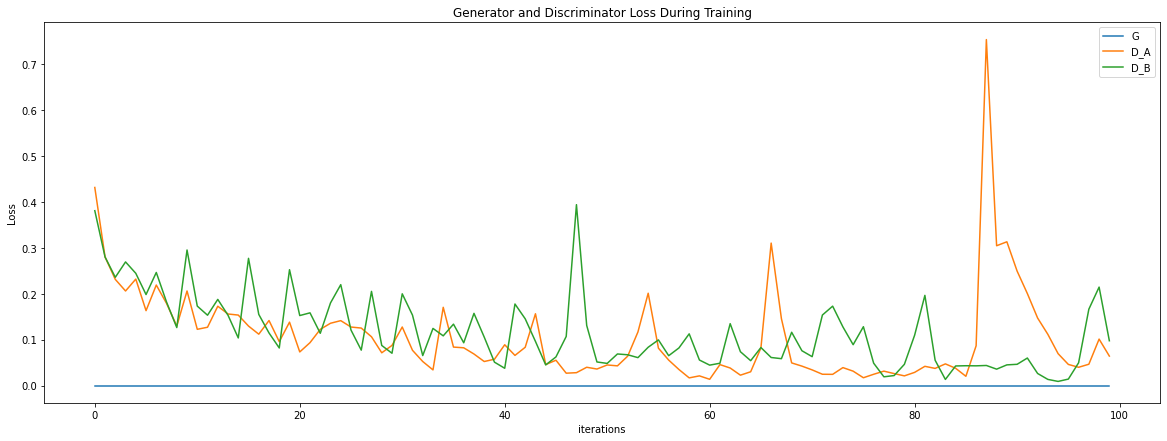

In [40]:
plt.figure(figsize=(20, 7))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(epoch_losses_G, label="G")
plt.plot(epoch_losses_D_A, label="D_A")
plt.plot(epoch_losses_D_B, label="D_B")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


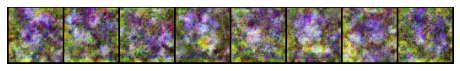

In [43]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = np.array(np.transpose(i, (1, 2, 0)) for i in img_list_A)
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list_A]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

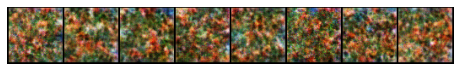

In [44]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")

ims = np.array(np.transpose(i, (1, 2, 0)) for i in img_list_B)
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list_B]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())